In [2]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import baltic as bt
from scipy.stats import linregress
import numpy as np
import pandas as pd
from itertools import combinations

In [3]:
cmap=mpl.cm.plasma
all_effects_color = cmap(0.4)
interserotype_effects_color = cmap(0.7)

all_tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'
allEffects_err_file = '../data/augur-output/all_effects/dengue_all_predicted_titers.csv'
interseroEffects_err_file = '../data/augur-output/interserotype_effects/dengue_all_predicted_titers.csv'
geno_pheno_file = './png/tip_distances.csv'
out_path = './png/'

In [4]:
all_tree = bt.loadJSON(all_tree_file, {'name': 'strain', 'height': 'xvalue'})
allEffects_err = pd.read_csv(allEffects_err_file, index_col=None)
interseroEffects_err = pd.read_csv(interseroEffects_err_file, index_col=None)


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [5]:
def find_distances(k1, k2, tree=all_tree):
    '''Finds trace between tip and vaccine_tip, 
    sums dTiter along all branches along the path, 
    and returns this distance.'''
    
    assert k1 in tree.Objects and k2 in tree.Objects
    
    k1_trace = []
    k2_trace = []
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else: # first shared node is the Most Recent Common Ancestor (MRCA)
        mrca = k
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional (doesn't matter, but makes my type-A brain happy)
    total_trace = [] # verbose for clarity
    total_trace += shared_k1_trace
    total_trace += k2_trace

    dTiter = sum([k.traits['dTiter'] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2    
    genetic_distance = sum([k.length for k in total_trace])
    homotypic = k1.traits['strain'][:5] == k2.traits['strain'][:5]
    return {'Antigenic distance': dTiter, 'Genetic distance': genetic_distance, 'homotypic': homotypic}

try:
    geno_pheno_df = pd.read_csv(geno_pheno_file, index_col=0)
except:
    leaves = [i for i in all_tree.Objects if i.branchType=='leaf']
    geno_pheno_df = pd.DataFrame([find_distances(k1,k2, tree=all_tree) for (k1,k2) in combinations(leaves,2)])
    geno_pheno_df.to_csv(out_path+'tip_distances.csv')

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
def plot_tree(ll, ax, cax, colorby='cTiter', cmap=cmap):
    sns.set(style='white')

    max_c = max([k.traits[colorby] for k in ll.Objects if colorby in k.traits ])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_c)
    cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, orientation='vertical', 
                                   norm=norm, label="Cumulative log2(titer) distance from root")    
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_ticks_position('left')

    cb.set_label("Cumulative log2(titer) distance from root", )

    branchWidth=2 ## default branch width
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c=cmap(k.traits[colorby]/max_c) ## or be a function of something else

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.set_yticks([])
    ax.set_xticks([round(x, 2) for x in np.linspace(0, ll.treeHeight, 5)])
    ax.set_ylim(-5,ll.ySpan+7)
    ax.set_xlabel('Substitutions per site')
    
def plot_performance(df, ax, c):
    x,y=df['actual'].head(20), df['predicted'].head(20)
    sns.regplot(x,y, ax=ax, scatter_kws={'alpha': 0.3}, color=c)
    fit = linregress(x,y)
    r = fit[2]
    rms_error=np.sqrt( sum([ (actual - predicted)**2 for (actual, predicted) in zip(x,y) ])/len(x))
    ax.text(0.08, 0.8,'r = %.2f'%r, transform=ax.transAxes)
    ax.text(0.08, 0.65, 'rms error = %.2f'%rms_error, transform=ax.transAxes)
    ax.set_xlabel('Actual log2(titer)')
    ax.set_ylabel('Predicted log2(titer)')
    
def plot_geno_pheno(foo, ax):
    df = foo.head(200)
    colors = [ all_effects_color if i==True else interserotype_effects_color for i in df['homotypic'].values]
    sns.regplot('Genetic distance', 'Antigenic distance', data=df, 
#                 scatter_kws={'color': colors, 'alpha': 0.1}, 
                line_kws={'color': 'lightgray'},
                ax=ax, x_bins=10)
    r=linregress(df['Genetic distance'], df['Antigenic distance'])[2]
    ax.text(0.08,0.8, 'r=%.2f'%r, transform=ax.transAxes)
    ax.set_xlabel('Genetic distance')
    ax.set_ylabel('Antigenic distance')

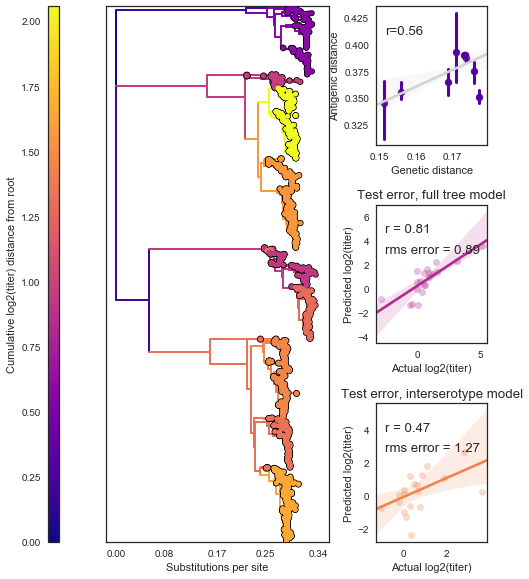

In [37]:
fig = plt.figure(figsize=(7.5, 8.25))
gs = gridspec.GridSpec(3,3, width_ratios=[0.1,2,1])
sns.set_palette('plasma')

cax = plt.subplot(gs[:,0])
allEffects_tree_ax = plt.subplot(gs[:,1])
geno_pheno_ax = plt.subplot(gs[0,-1])
allEffects_err_ax = plt.subplot(gs[1,-1])
interseroEffects_err_ax = plt.subplot(gs[2,-1])

sns.set(style='white', font_scale=1.3)
plot_tree(all_tree, ax=allEffects_tree_ax, cax=cax, cmap=cmap)

sns.set(style='whitegrid', font_scale=1.1)
plot_geno_pheno(geno_pheno_df, geno_pheno_ax)

plot_performance(allEffects_err, allEffects_err_ax, c=all_effects_color)
allEffects_err_ax.set_title('Test error, full tree model')

plot_performance(interseroEffects_err, interseroEffects_err_ax, c=interserotype_effects_color)
interseroEffects_err_ax.set_title('Test error, interserotype model')

plt.tight_layout(h_pad=1.08, w_pad=0.5)
plt.show()